# Simple Starter Notebook for;
## UmojaHack Africa 2021 #2: Sendy - Delivery Rider Response Challenge by UmojaHack Africa

Can you predict who is the best delivery rider for an order placed via logistics company Sendy?

![Umoja Hack](https://zindpublic.blob.core.windows.net/public/uploads/competition/image/152/thumb_c5ec4e2a-e000-4176-a93c-dd1143c2b60f.png)

The objective of this challenge is to create a machine learning model that will predict whether a rider will accept, decline or ignore an order sent to them.

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from math import sin, cos, sqrt, atan2, radians

from imblearn.over_sampling import RandomOverSampler, SMOTE

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()

In [2]:
# Setting random seed for reproducible results

#from tensorflow.python.client import device_lib 

np.random.seed(42)
#tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'

#print(device_lib.list_local_devices())

In [3]:
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
riders = pd.read_csv('Riders.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
# check data shapes
train.shape, test.shape, riders.shape, ss.shape

((179867, 21), (76791, 20), (2632, 4), (76791, 2))

In [6]:
# Preview train
train.head()

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,2
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,1
3,ID_LKSVPNYMTR,44869,22,3,14:11:16,1504660,Personal,0,2,Bike,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,2
4,ID_O7N8Y918YH,57590,27,5,16:11:38,36869,Business,0,2,Bike,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,0


In [7]:
# Preview riders
riders.head()

,Rider ID,Active Rider Age,Average Partner Rating,Number of Ratings
0,16261,308,21.05,321
1,8832,224,10.00,27
2,53866,238,17.76,25
3,46368,343,24.56,320
4,45609,399,14.97,214


In [8]:
# Merge rider dataset to train and test sets
train = train.merge(riders, how = 'left', left_on='rider_id', right_on='Rider ID')
test = test.merge(riders, how = 'left', left_on='rider_id', right_on='Rider ID')

# Preview merged dataframe
train.head()

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target,Rider ID,Active Rider Age,Average Partner Rating,Number of Ratings
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,30153,11,10.00,1
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,2,20884,68,24.13,229
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,1,33143,273,24.92,123
3,ID_LKSVPNYMTR,44869,22,3,14:11:16,1504660,Personal,0,2,Bike,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,2,96531,168,23.76,175
4,ID_O7N8Y918YH,57590,27,5,16:11:38,36869,Business,0,2,Bike,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,0,103546,95,24.53,42


In [9]:
train.head(10)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target,Rider ID,Active Rider Age,Average Partner Rating,Number of Ratings
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,30153,11,10.00,1
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,2,20884,68,24.13,229
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,1,33143,273,24.92,123
3,ID_LKSVPNYMTR,44869,22,3,14:11:16,1504660,Personal,0,2,Bike,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,2,96531,168,23.76,175
4,ID_O7N8Y918YH,57590,27,5,16:11:38,36869,Business,0,2,Bike,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,0,103546,95,24.53,42
5,ID_QG327RXJZ7,2374,22,5,08:12:54,75647,Business,0,1,Bike,66125,1,1,400,-42.841559,-17.242244,-42.813452,-17.233333,-42.794423,-17.244687,0,66125,182,23.96,57
6,ID_MRC2RIJGUA,7071,14,4,09:11:35,85261,Business,0,1,Bike,66033,1,1,400,-42.816480,-17.277562,-42.805966,-17.287565,-42.802569,-17.252329,0,66033,124,10.00,4
7,ID_HDUCBCXLC1,50041,3,3,15:09:26,151271,Business,0,1,Bike,45701,0,1,420,-42.842417,-17.312222,-42.843415,-17.318960,-42.855423,-17.292512,0,45701,56,10.00,12
8,ID_XZC11Y3PJL,46731,18,5,15:01:55,593630,Business,0,2,Bike,117622,0,1,420,-42.776085,-17.289053,-42.781209,-17.297432,-42.737458,-17.278413,0,117622,40,24.54,87
9,ID_T0VWF98B3X,2413,28,6,08:12:49,59363,Business,0,2,Bike,40066,0,0,800,-42.825127,-17.279260,-42.831152,-17.276845,-42.968853,-17.283623,0,40066,0,23.78,100


In [10]:
train.describe()

,order_id,dispatch_day,dispatch_day_of_week,client_id,order_license_status,order_carrier_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target,Rider ID,Active Rider Age,Average Partner Rating,Number of Ratings
count,179867.000000,179867.000000,179867.000000,1.798670e+05,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000,179867.000000
mean,32639.833149,16.604903,4.185198,4.654108e+05,0.239555,1.619007,70389.969944,0.589936,0.868731,517.544185,-42.817124,-17.286813,-42.817156,-17.286229,-42.814879,-17.282547,0.652843,70389.969944,141.981497,17.250388,82.793948
std,18227.428596,8.528368,1.683574,6.634234e+05,0.426813,0.536552,33981.806096,0.491846,0.337695,157.385430,0.106837,0.100707,0.106425,0.100101,0.114158,0.103640,0.791099,33981.806096,90.447924,6.250999,103.392784
min,100.000000,1.000000,1.000000,2.610000e+02,0.000000,0.000000,1817.000000,0.000000,0.000000,200.000000,-45.736540,-20.079067,-45.725110,-20.070241,-45.793523,-20.352897,0.000000,1817.000000,0.000000,1.000000,0.000000
25%,16875.000000,9.000000,3.000000,7.564700e+04,0.000000,1.000000,40756.000000,0.000000,1.000000,410.000000,-42.832252,-17.301329,-42.829119,-17.299970,-42.830628,-17.301066,0.000000,40756.000000,70.000000,10.000000,12.000000
50%,32964.000000,17.000000,4.000000,1.434280e+05,0.000000,2.000000,73485.000000,1.000000,1.000000,460.000000,-42.813961,-17.286776,-42.820037,-17.283554,-42.806976,-17.282880,0.000000,73485.000000,134.000000,19.020000,49.000000
75%,48117.000000,24.000000,6.000000,5.936300e+05,0.000000,2.000000,100441.000000,1.000000,1.000000,570.000000,-42.791405,-17.264774,-42.789742,-17.263246,-42.783811,-17.259310,1.000000,100441.000000,196.000000,22.970000,110.000000
max,64427.000000,31.000000,7.000000,2.568456e+06,1.000000,2.000000,123694.000000,1.000000,1.000000,2190.000000,-40.676917,-15.480446,-40.699055,-15.482671,-40.683763,-15.324765,2.000000,123694.000000,399.000000,24.960000,637.000000


In [11]:
# checking to see if there are any duplicate features present

train.duplicated().sum()

0

In [12]:
# Analysising the dataset to see if there are missing variables present

train.isna().sum()

ID                        0
order_id                  0
dispatch_day              0
dispatch_day_of_week      0
dispatch_time             0
client_id                 0
client_type               0
order_license_status      0
order_carrier_type        0
vendor_type               0
rider_id                  0
rider_license_status      0
rider_carrier_type        0
rider_amount              0
rider_lat                 0
rider_long                0
pickup_lat                0
pickup_long               0
drop_off_lat              0
drop_off_long             0
target                    0
Rider ID                  0
Active Rider Age          0
Average Partner Rating    0
Number of Ratings         0
dtype: int64

In [13]:
# checking for data imbalance

train.target.value_counts()

0    98343
1    45623
2    35901
Name: target, dtype: int64

In [14]:
# Feature Engineering
# Ensure you have gotten rid of as much noise as possible before doing this

client_list = list(train['client_id'].unique())

def num_rating(x):
    if x > 0 and x <= 15:
        return 1
    if x > 15 and x <= 110:
        return 2
    else:
        return 3

def average_rating(x):
    if x > 1 and x <= 15:
        return 1
    elif x > 15 and x <= 23:
        return 2
    else: 
        return 3

def rider_age(x):
    if x > 0 and x <= 100:
        return 1
    elif x > 100 and x <= 200:
        return 2
    else:
        return 3

def rider_amount(x):
    if x > 200 and x <= 400:
        return 1
    elif x > 400 and x <= 600:
        return 2
    else:
        return 3

def time_convert(x):
    word = x.split(':')
    ident = word[0]
    idint = int(ident)
    
    return idint
    
train['dispatch_day_of_week'] = train['dispatch_day_of_week'].apply(lambda x: 'weekday' if x < 6 else 'weekend')
test['dispatch_day_of_week'] = test['dispatch_day_of_week'].apply(lambda x: 'weekday' if x < 6 else 'weekend')

train['dispatch_time'] = train['dispatch_time'].apply(time_convert)
test['dispatch_time'] = test['dispatch_time'].apply(time_convert)

#train['rider_amount'] = train['rider_amount'].apply(rider_amount)

#train['Active Rider Age'] = train['Active Rider Age'].apply(rider_age)

#train['Average Partner Rating'] = train['Average Partner Rating'].apply(average_rating)

#train['Number of Ratings'] = train['Number of Ratings'].apply(num_rating)

In [15]:
train.head()

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target,Rider ID,Active Rider Age,Average Partner Rating,Number of Ratings
0,ID_SCUW21PVAU,4435,27,weekend,9,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,30153,11,10.00,1
1,ID_2HA7X30JMN,32711,30,weekend,13,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,2,20884,68,24.13,229
2,ID_IAJWDTBY6M,8712,14,weekday,10,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,1,33143,273,24.92,123
3,ID_LKSVPNYMTR,44869,22,weekday,14,1504660,Personal,0,2,Bike,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,2,96531,168,23.76,175
4,ID_O7N8Y918YH,57590,27,weekday,16,36869,Business,0,2,Bike,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,0,103546,95,24.53,42


In [16]:
from math import radians
train['rider_lat'] = train['rider_lat'].apply(lambda x: radians(abs(x)))
train['pickup_lat'] = train['pickup_lat'].apply(lambda x: radians(abs(x)))
train['drop_off_lat'] = train['drop_off_lat'].apply(lambda x: radians(abs(x)))
train['rider_long'] = train['rider_long'].apply(lambda x: radians(abs(x)))
train['pickup_long'] = train['pickup_long'].apply(lambda x: radians(abs(x)))
train['drop_off_long'] = train['drop_off_long'].apply(lambda x: radians(abs(x)))

test['rider_lat'] = test['rider_lat'].apply(lambda x: radians(abs(x)))
test['pickup_lat'] = test['pickup_lat'].apply(lambda x: radians(abs(x)))
test['drop_off_lat'] = test['drop_off_lat'].apply(lambda x: radians(abs(x)))
test['rider_long'] = test['rider_long'].apply(lambda x: radians(abs(x)))
test['pickup_long'] = test['pickup_long'].apply(lambda x: radians(abs(x)))
test['drop_off_long'] = test['drop_off_long'].apply(lambda x: radians(abs(x)))


train['dlat'] = train['rider_lat'] - train['pickup_lat']
train['dlon'] = train['rider_long'] - train['pickup_long']
train['dlat2'] = train['pickup_lat'] - train['drop_off_lat']
train['dlon2'] = train['pickup_long'] - train['drop_off_long']

test['dlat'] = test['rider_lat'] - test['pickup_lat']
test['dlon'] = test['rider_long'] - test['pickup_long']
test['dlat2'] = test['pickup_lat'] - test['drop_off_lat']
test['dlon2'] = test['pickup_long'] - test['drop_off_long']

In [17]:
# One hot encoding
train = pd.get_dummies(train, columns=['client_type', 'dispatch_day_of_week'])
test = pd.get_dummies(test, columns=['client_type', 'dispatch_day_of_week'])

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179867 entries, 0 to 179866
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ID                            179867 non-null  object 
 1   order_id                      179867 non-null  int64  
 2   dispatch_day                  179867 non-null  int64  
 3   dispatch_time                 179867 non-null  int64  
 4   client_id                     179867 non-null  int64  
 5   order_license_status          179867 non-null  int64  
 6   order_carrier_type            179867 non-null  int64  
 7   vendor_type                   179867 non-null  object 
 8   rider_id                      179867 non-null  int64  
 9   rider_license_status          179867 non-null  int64  
 10  rider_carrier_type            179867 non-null  int64  
 11  rider_amount                  179867 non-null  int64  
 12  rider_lat                     179867 non-nul

In [19]:
train.head()

,ID,order_id,dispatch_day,dispatch_time,client_id,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target,Rider ID,Active Rider Age,Average Partner Rating,Number of Ratings,dlat,dlon,dlat2,dlon2,client_type_Business,client_type_Personal,dispatch_day_of_week_weekday,dispatch_day_of_week_weekend
0,ID_SCUW21PVAU,4435,27,9,593630,0,2,Bike,30153,0,1,1080,0.745227,0.300695,0.745122,0.301040,0.745036,0.304118,1,30153,11,10.00,1,0.000104,-0.000345,0.000086,-0.003078,1,0,0,1
1,ID_2HA7X30JMN,32711,30,13,837729,0,1,Bike,20884,0,1,730,0.746780,0.301737,0.746722,0.301770,0.744789,0.300800,2,20884,68,24.13,229,0.000057,-0.000033,0.001933,0.000969,0,1,0,1
2,ID_IAJWDTBY6M,8712,14,10,695129,0,2,Bike,33143,1,1,490,0.746114,0.301730,0.746394,0.301833,0.747244,0.301851,1,33143,273,24.92,123,-0.000280,-0.000104,-0.000851,-0.000018,0,1,1,0
3,ID_LKSVPNYMTR,44869,22,14,1504660,0,2,Bike,96531,1,1,510,0.747634,0.302150,0.747558,0.302209,0.747218,0.301339,2,96531,168,23.76,175,0.000076,-0.000059,0.000340,0.000870,0,1,1,0
4,ID_O7N8Y918YH,57590,27,16,36869,0,2,Bike,103546,0,0,400,0.747493,0.302340,0.747630,0.302258,0.747499,0.301978,0,103546,95,24.53,42,-0.000137,0.000082,0.000132,0.000280,1,0,1,0


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179867 entries, 0 to 179866
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ID                            179867 non-null  object 
 1   order_id                      179867 non-null  int64  
 2   dispatch_day                  179867 non-null  int64  
 3   dispatch_time                 179867 non-null  int64  
 4   client_id                     179867 non-null  int64  
 5   order_license_status          179867 non-null  int64  
 6   order_carrier_type            179867 non-null  int64  
 7   vendor_type                   179867 non-null  object 
 8   rider_id                      179867 non-null  int64  
 9   rider_license_status          179867 non-null  int64  
 10  rider_carrier_type            179867 non-null  int64  
 11  rider_amount                  179867 non-null  int64  
 12  rider_lat                     179867 non-nul

In [21]:
# approximate radius of earth in km
R = 6373.0

train['dlat'] = train['dlat'].apply(lambda x: (sin(x)/2)**2)
train['pickup_lat'] = train['pickup_lat'].apply(lambda x: cos(x))
train['rider_lat'] = train['rider_lat'].apply(lambda x: cos(x))
train['dlon'] = train['dlon'].apply(lambda x: (sin(x)/2)**2)


test['dlat'] = test['dlat'].apply(lambda x: (sin(x)/2)**2)
test['pickup_lat'] = test['pickup_lat'].apply(lambda x: cos(x))
test['rider_lat'] = test['rider_lat'].apply(lambda x: cos(x))
test['dlon'] = test['dlon'].apply(lambda x: (sin(x)/2)**2)


train['a'] = train['dlat'] + train['pickup_lat'] * train['rider_lat'] * train['dlon']
test['a'] = test['dlat'] + test['pickup_lat'] * test['rider_lat'] * test['dlon']

###############################################################################################

train['dlat2'] = train['dlat2'].apply(lambda x: (sin(x)/2)**2)
#train['pickup_lat'] = train['pickup_lat'].apply(lambda x: cos(x))
train['drop_off_lat'] = train['drop_off_lat'].apply(lambda x: cos(x))
train['dlon2'] = train['dlon2'].apply(lambda x: (sin(x)/2)**2)

test['dlat2'] = test['dlat2'].apply(lambda x: (sin(x)/2)**2)
#test['pickup_lat'] = test['pickup_lat'].apply(lambda x: cos(x))
test['drop_off_lat'] = test['drop_off_lat'].apply(lambda x: cos(x))
test['dlon2'] = test['dlon2'].apply(lambda x: (sin(x)/2)**2)

train['a2'] = train['dlat2'] + train['pickup_lat'] * train['drop_off_lat'] * train['dlon2']
test['a2'] = test['dlat2'] + test['pickup_lat'] * test['drop_off_lat'] * test['dlon2']


#################################################################################################################

train['distance'] = train['a'].apply(lambda x: 2 * (atan2(sqrt(x), sqrt(1-x))) * R)
train['distance2'] = train['a2'].apply(lambda x: 2 * (atan2(sqrt(x), sqrt(1-x))) * R)

test['distance'] = test['a'].apply(lambda x: 2 * (atan2(sqrt(x), sqrt(1-x))) * R)

test['distance2'] = test['a2'].apply(lambda x: 2 * (atan2(sqrt(x), sqrt(1-x))) * R)

###########################################################################################################

#a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
#c = 2 * atan2(sqrt(a), sqrt(1 - a))

#distance = R * c


In [22]:
train['distance3'] = train['distance'] + train['distance2']

test['distance3'] = test['distance'] + test['distance2']

In [23]:
train.head()

,ID,order_id,dispatch_day,dispatch_time,client_id,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target,Rider ID,Active Rider Age,Average Partner Rating,Number of Ratings,dlat,dlon,dlat2,dlon2,client_type_Business,client_type_Personal,dispatch_day_of_week_weekday,dispatch_day_of_week_weekend,a,a2,distance,distance2,distance3
0,ID_SCUW21PVAU,4435,27,9,593630,0,2,Bike,30153,0,1,1080,0.734934,0.300695,0.735005,0.301040,0.735063,0.304118,1,30153,11,10.00,1,2.715938e-09,2.975130e-08,1.850173e-09,2.369069e-06,1,0,0,1,1.878700e-08,1.281799e-06,1.747039,14.430587,16.177627
1,ID_2HA7X30JMN,32711,30,13,837729,0,1,Bike,20884,0,1,730,0.733880,0.301737,0.733919,0.301770,0.735231,0.300800,2,20884,68,24.13,229,8.146596e-10,2.660194e-10,9.345590e-07,2.347934e-07,0,1,0,1,9.579399e-10,1.061254e-06,0.394496,13.130569,13.525066
2,ID_IAJWDTBY6M,8712,14,10,695129,0,2,Bike,33143,1,1,490,0.734332,0.301730,0.734142,0.301833,0.733564,0.301851,1,33143,273,24.92,123,1.955502e-08,2.683382e-09,1.809818e-07,7.935532e-11,0,1,1,0,2.100164e-08,1.810246e-07,1.847143,5.423038,7.270182
3,ID_LKSVPNYMTR,44869,22,14,1504660,0,2,Bike,96531,1,1,510,0.733300,0.302150,0.733351,0.302209,0.733583,0.301339,2,96531,168,23.76,175,1.443284e-09,8.756899e-10,2.896749e-08,1.893948e-07,0,1,1,0,1.914201e-09,1.308570e-07,0.557658,4.610758,5.168416
4,ID_O7N8Y918YH,57590,27,16,36869,0,2,Bike,103546,0,0,400,0.733395,0.302340,0.733302,0.302258,0.733392,0.301978,0,103546,95,24.53,42,4.705743e-09,1.687336e-09,4.328693e-09,1.964029e-08,1,0,1,0,5.613193e-09,1.489120e-08,0.954946,1.555388,2.510334


In [24]:
# train.drop(['rider_lat', 'rider_long', 'pickup_lat', 'pickup_long', 'drop_off_lat',
#        'drop_off_long', 'dlat', 'dlat2', 'dlon', 'dlon2', 'a', 'a2'], axis=1, inplace=True)

# test.drop(['rider_lat', 'rider_long', 'pickup_lat', 'pickup_long', 'drop_off_lat',
#        'drop_off_long', 'dlat', 'dlat2', 'dlon', 'dlon2', 'a', 'a2'], axis=1, inplace=True)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179867 entries, 0 to 179866
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ID                            179867 non-null  object 
 1   order_id                      179867 non-null  int64  
 2   dispatch_day                  179867 non-null  int64  
 3   dispatch_time                 179867 non-null  int64  
 4   client_id                     179867 non-null  int64  
 5   order_license_status          179867 non-null  int64  
 6   order_carrier_type            179867 non-null  int64  
 7   vendor_type                   179867 non-null  object 
 8   rider_id                      179867 non-null  int64  
 9   rider_license_status          179867 non-null  int64  
 10  rider_carrier_type            179867 non-null  int64  
 11  rider_amount                  179867 non-null  int64  
 12  rider_lat                     179867 non-nul

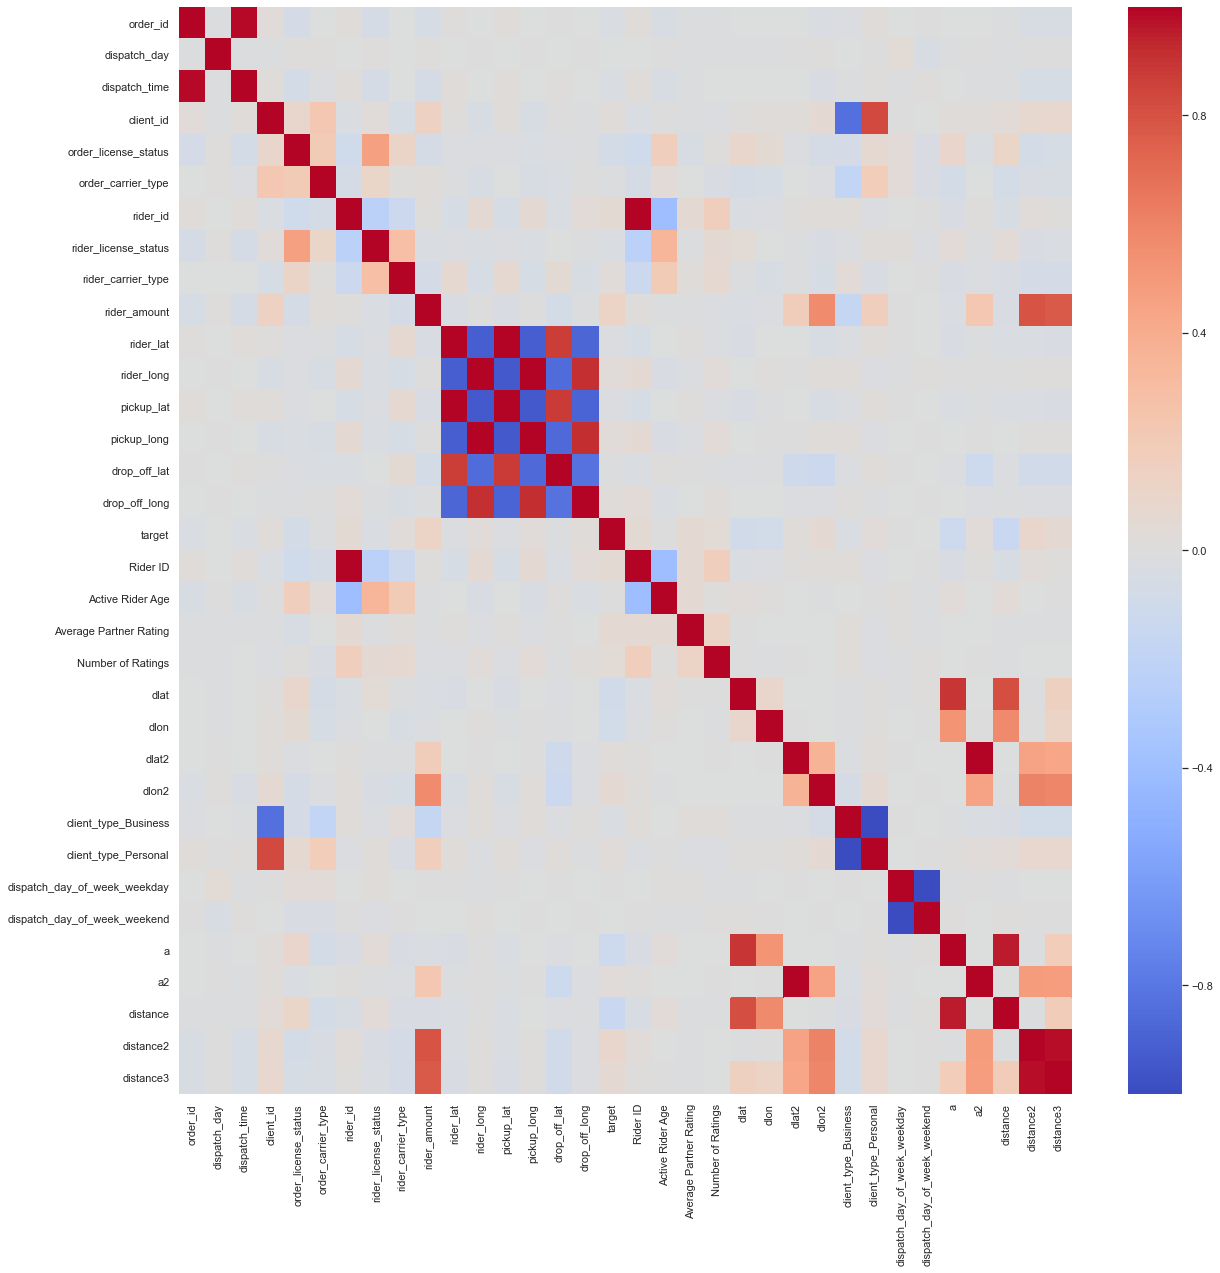

In [26]:
plt.figure(figsize=(20,20))

sns.heatmap(train.corr(), cmap='coolwarm')

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179867 entries, 0 to 179866
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ID                            179867 non-null  object 
 1   order_id                      179867 non-null  int64  
 2   dispatch_day                  179867 non-null  int64  
 3   dispatch_time                 179867 non-null  int64  
 4   client_id                     179867 non-null  int64  
 5   order_license_status          179867 non-null  int64  
 6   order_carrier_type            179867 non-null  int64  
 7   vendor_type                   179867 non-null  object 
 8   rider_id                      179867 non-null  int64  
 9   rider_license_status          179867 non-null  int64  
 10  rider_carrier_type            179867 non-null  int64  
 11  rider_amount                  179867 non-null  int64  
 12  rider_lat                     179867 non-nul

In [28]:
train.columns

Index(['ID', 'order_id', 'dispatch_day', 'dispatch_time', 'client_id',
       'order_license_status', 'order_carrier_type', 'vendor_type', 'rider_id',
       'rider_license_status', 'rider_carrier_type', 'rider_amount',
       'rider_lat', 'rider_long', 'pickup_lat', 'pickup_long', 'drop_off_lat',
       'drop_off_long', 'target', 'Rider ID', 'Active Rider Age',
       'Average Partner Rating', 'Number of Ratings', 'dlat', 'dlon', 'dlat2',
       'dlon2', 'client_type_Business', 'client_type_Personal',
       'dispatch_day_of_week_weekday', 'dispatch_day_of_week_weekend', 'a',
       'a2', 'distance', 'distance2', 'distance3'],
      dtype='object')

In [29]:
from sklearn.ensemble import VotingClassifier

In [40]:
# Split data

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

main_cols = train.columns.difference([
    'ID',
    'order_id',
    'Rider ID',
    'target',
    'client_id',
    'vendor_type',
    'distance2', 'dlat', 'dlon', 'dlat2',
    'dlon2',
    'dispatch_day_of_week_weekend', 'a',
    'a2', 'client_type_Business'
    
    
]).tolist()

from sklearn.preprocessing import MinMaxScaler

X = train[main_cols]
y = train.target



X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.001,
                                                    stratify=y,
                                                    random_state=42)


# Train a model
model = VotingClassifier(estimators=[('lg', LogisticRegression(max_iter=1000,verbose=10)), ('rf', RandomForestClassifier(n_estimators=500, verbose=10)), ('lgbm', LGBMClassifier(n_estimators=800, verbose=10))], verbose=True)

#model = XGBClassifier(n_estimators=800, random_state=42)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check score
accuracy_score(y_test, y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s finished


[Voting] ....................... (1 of 3) Processing lg, total=   9.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 500


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


building tree 3 of 500


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s


building tree 4 of 500


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s


building tree 5 of 500


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s remaining:    0.0s


building tree 6 of 500


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.8s remaining:    0.0s


building tree 7 of 500


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.4s remaining:    0.0s


building tree 8 of 500


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.1s remaining:    0.0s


building tree 9 of 500


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.8s remaining:    0.0s


building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51

building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.5min finished


[Voting] ....................... (2 of 3) Processing rf, total= 5.5min
[Voting] ..................... (3 of 3) Processing lgbm, total=  39.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


0.5944444444444444

In [41]:
# Make predictions in test set and prepare submission file

predictions = model.predict(test[main_cols])
sub_file = ss.copy()
sub_file.target = predictions
sub_file.to_csv('10.csv', index = False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   16.3s finished
